In [1]:
using Pkg
Pkg.activate(".")
using Plots, StatsBase, CodecZlib, CSV, DataFrames, LinearAlgebra, TextSearch, Formatting, Latexify, UMAP, SimilaritySearch, JLD2


  Activating project at `~/Research/RegionalSpanish/notebooks`


In [2]:
VOC = CSV.read("../data/SpanishLang/voc.tsv.gz", DataFrame, delim='\t')
@info names(VOC)

┌ Info: ["token", "country_code", "ndocs", "idf"]
└ @ Main In[2]:2


In [3]:
#VOC |> @filter(_.token == "cantina") |> DataFrame
subset(VOC, :token => t -> t .== "zopilote") |> display
subset(VOC, :token => t -> t .== "xoloescuincle") |> display
subset(VOC, :token => arr -> [t in ("guajolote", "pavo") for t in arr]) |> display


,token,country_code,ndocs,idf
,String,String3,Int64,Float64
1,zopilote,AR,12,16.1164
2,zopilote,CL,6,14.9771
3,zopilote,CO,11,14.8183
4,zopilote,CR,51,11.2022
5,zopilote,EC,6,13.7061
6,zopilote,ES,20,14.9082
7,zopilote,GT,25,11.5421
8,zopilote,HN,12,11.3633
9,zopilote,MX,417,11.8021


,token,country_code,ndocs,idf
,String,String3,Int64,Float64
1,xoloescuincle,MX,30,14.4036
2,xoloescuincle,ALL,30,16.3671


,token,country_code,ndocs,idf
,String,String3,Int64,Float64
1,guajolote,AR,9,16.3787
2,guajolote,MX,802,11.1492
3,guajolote,US,83,12.2264
4,guajolote,ALL,894,13.0042
5,pavo,AR,12905,9.21586
6,pavo,BO,19,10.1017
7,pavo,BR,76,10.8129
8,pavo,CA,101,8.91048
9,pavo,CL,3466,8.77195


In [4]:
common = DataFrame(token=String[], n_regions=Int[], idf=Float64[], country_codes=[])

for g in groupby(VOC, :token)
    n_regions = length(g.token) - 1
    idf = sum(row.idf for row in eachrow(g) if row.country_code != "ALL") / n_regions
    regions = join(g.country_code, ',')
    push!(common, (first(g.token), n_regions, idf, regions))
end

open("../data/SpanishLang/common-tokens-per-region.tsv.gz", "w") do f
    gz = GzipCompressorStream(f)
    CSV.write(gz, common, delim='\t')
    close(gz)
end

common

,token,n_regions,idf,country_codes
,String,Int64,Float64,Any
1,!,26,2.69968,"AR,BO,BR,CA,CL,CO,CR,CU,DO,EC,ES,FR,GB,GQ,GT,HN,MX,NI,PA,PE,PR,PY,SV,US,UY,VE,ALL"
2,!!,26,3.19267,"AR,BO,BR,CA,CL,CO,CR,CU,DO,EC,ES,FR,GB,GQ,GT,HN,MX,NI,PA,PE,PR,PY,SV,US,UY,VE,ALL"
3,"!!""",24,9.63197,"AR,BO,BR,CA,CL,CO,CR,DO,EC,ES,FR,GB,GT,HN,MX,NI,PA,PE,PR,PY,SV,US,UY,VE,ALL"
4,!!#,14,12.7775,"AR,CA,CL,CO,ES,GT,MX,PA,PE,PY,SV,US,UY,VE,ALL"
5,!!$,12,13.3454,"AR,BR,CL,CO,EC,ES,MX,PE,PY,US,UY,VE,ALL"
6,!!%,2,16.1646,"AR,MX,ALL"
7,!!&,8,14.4336,"AR,CL,CO,ES,MX,US,UY,VE,ALL"
8,!!',24,11.1774,"AR,BO,BR,CA,CL,CO,CR,DO,EC,ES,FR,GB,GT,HN,MX,NI,PA,PE,PR,PY,SV,US,UY,VE,ALL"
9,!!(,21,11.7663,"AR,BO,BR,CA,CL,CO,CR,DO,EC,ES,FR,GB,GT,MX,PA,PE,PY,SV,US,UY,VE,ALL"


In [5]:
X = [1]
Y = [size(common, 1)]

C = common

for min_count in 2:26
    C = subset(C, :n_regions => c -> c .> min_count)
    push!(X, min_count)
    push!(Y, size(C, 1))
end


┌ Info: [(1, 1268420), (2, 379143), (3, 302612), (4, 253685), (5, 218203), (6, 190432), (7, 167613), (8, 148445), (9, 131798), (10, 117963), (11, 105880), (12, 95728), (13, 86902), (14, 79079), (15, 72110), (16, 65710), (17, 59680), (18, 53992), (19, 48822), (20, 43609), (21, 38319), (22, 31882), (23, 20811), (24, 11718), (25, 1056), (26, 0)]
└ @ Main In[6]:1
┌ Warning: Skipped marker arg o.
└ @ Plots /home/sadit/.julia/packages/Plots/YAlrZ/src/args.jl:1229


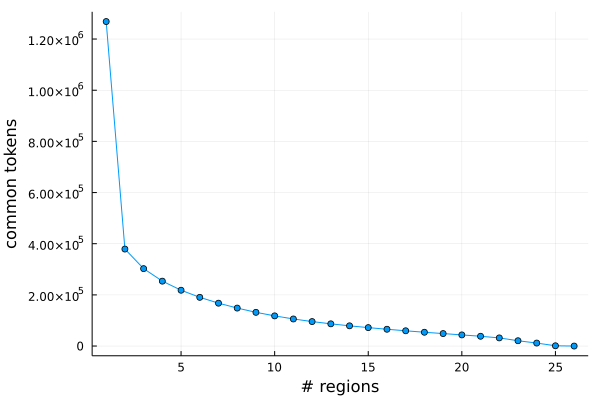

In [6]:
@info collect(zip(X, Y))
plot(X, Y, ylabel="common tokens", xlabel="# regions", m='o', label="")
savefig("../figs/fig-common-tokens-per-region.pdf")
savefig("../figs/fig-common-tokens-per-region.png")
plot!(fmt=:png)

In [7]:
C = subset(common, :n_regions => c -> c .>= 10)
sort!(C, :n_regions, by=last, rev=true)
first(C, 10) |> display
last(C, 10) |> display

,token,n_regions,idf,country_codes
,String,Int64,Float64,Any
1,!,26,2.69968,"AR,BO,BR,CA,CL,CO,CR,CU,DO,EC,ES,FR,GB,GQ,GT,HN,MX,NI,PA,PE,PR,PY,SV,US,UY,VE,ALL"
2,!!,26,3.19267,"AR,BO,BR,CA,CL,CO,CR,CU,DO,EC,ES,FR,GB,GQ,GT,HN,MX,NI,PA,PE,PR,PY,SV,US,UY,VE,ALL"
3,"""",26,3.28405,"AR,BO,BR,CA,CL,CO,CR,CU,DO,EC,ES,FR,GB,GQ,GT,HN,MX,NI,PA,PE,PR,PY,SV,US,UY,VE,ALL"
4,""",",26,6.05476,"AR,BO,BR,CA,CL,CO,CR,CU,DO,EC,ES,FR,GB,GQ,GT,HN,MX,NI,PA,PE,PR,PY,SV,US,UY,VE,ALL"
5,""".",26,5.48773,"AR,BO,BR,CA,CL,CO,CR,CU,DO,EC,ES,FR,GB,GQ,GT,HN,MX,NI,PA,PE,PR,PY,SV,US,UY,VE,ALL"
6,"""..",26,7.0065,"AR,BO,BR,CA,CL,CO,CR,CU,DO,EC,ES,FR,GB,GQ,GT,HN,MX,NI,PA,PE,PR,PY,SV,US,UY,VE,ALL"
7,"""?",26,7.59475,"AR,BO,BR,CA,CL,CO,CR,CU,DO,EC,ES,FR,GB,GQ,GT,HN,MX,NI,PA,PE,PR,PY,SV,US,UY,VE,ALL"
8,%,26,5.45701,"AR,BO,BR,CA,CL,CO,CR,CU,DO,EC,ES,FR,GB,GQ,GT,HN,MX,NI,PA,PE,PR,PY,SV,US,UY,VE,ALL"
9,&,26,6.37904,"AR,BO,BR,CA,CL,CO,CR,CU,DO,EC,ES,FR,GB,GQ,GT,HN,MX,NI,PA,PE,PR,PY,SV,US,UY,VE,ALL"


,token,n_regions,idf,country_codes
,String,Int64,Float64,Any
1,🕋,10,13.6664,"AR,CL,CO,EC,ES,HN,MX,PE,US,VE,ALL"
2,🖨,10,13.4959,"AR,CL,CO,EC,ES,GT,MX,PE,US,VE,ALL"
3,🖲,10,14.2037,"AR,CL,CO,EC,ES,MX,PE,US,UY,VE,ALL"
4,🗄,10,14.0817,"AR,CL,CO,EC,ES,HN,MX,PY,US,UY,ALL"
5,🛅,10,13.9273,"AR,BR,CL,CO,DO,EC,ES,MX,PE,US,ALL"
6,🥠,10,13.9888,"AR,CL,CO,CR,ES,MX,PA,PE,US,VE,ALL"
7,🥼,10,13.9269,"AR,CO,CR,EC,ES,HN,MX,US,UY,VE,ALL"
8,🥾,10,13.5012,"AR,BO,CL,CO,EC,ES,MX,PE,SV,US,ALL"
9,🧕,10,13.5994,"AR,CL,CO,ES,MX,PA,PE,US,UY,VE,ALL"
